In [34]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from scipy.io import loadmat

import earthpy.plot as ep
import earthpy.spatial as es

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm


In [35]:
#load the dataset
X = loadmat("PaviaU.mat")["paviaU"]
y = loadmat("PaviaU_gt.mat")["paviaU_gt"]

In [36]:
X.shape, y.shape

((610, 340, 103), (610, 340))

In [37]:
pavia_df = pd.DataFrame(X.reshape(X.shape[0]*X.shape[1], -1))

In [38]:
pavia_df.columns = [f"band{i}" for i in range(1, pavia_df.shape[-1]+1)]

pavia_df["class"] = y.ravel()

In [ ]:
#visualizing the bands
fig = plt.figure(figsize = (10, 8))

ax = fig.subplots(2, 5)

for i in range(2):
    
    for j in range(5):
        c = np.random.randint(103)
        ax[i][j].imshow(X[:, :, c], cmap = "nipy_spectral")
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1

plt.tight_layout()
plt.show()

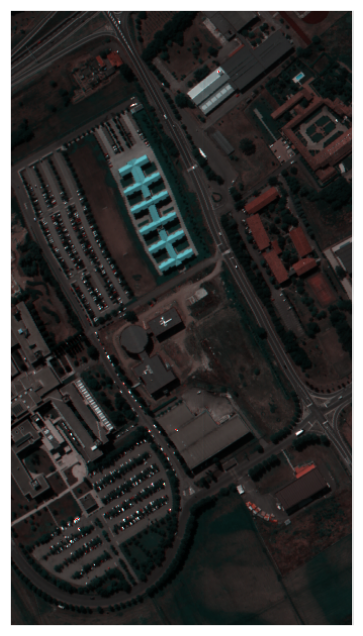

In [40]:
mdata = np.moveaxis(X, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize = (10,8)) 

plt.show()

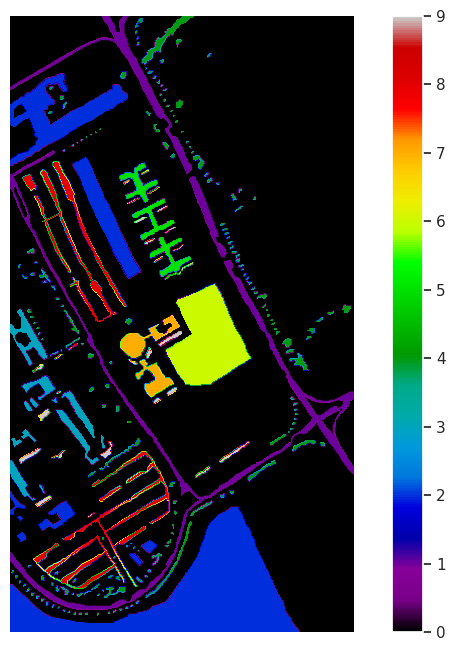

In [41]:
#visualizing of groundtruth

def plot_data(data):
    fig = plt.figure(figsize = (10,8))
    plt.imshow(y, cmap = "nipy_spectral")
    plt.colorbar()
    plt.axis("off")
    plt.show()

plot_data(y)

In [42]:
X = pavia_df[pavia_df["class"]!=0].iloc[:, :-1].values

y = tf.keras.utils.to_categorical(pavia_df[pavia_df["class"]!=0].iloc[:, -1].values , num_classes = np.unique(y).shape[0], dtype = "float32")

names = ["Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets", "Bare Soil", "Bitumen", "Self-Blocking Bricks", "Shadows"]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [44]:
X_train.shape, X_test.shape

((29943, 103), (12833, 103))

In [45]:
model = Sequential(name = "Pavia_University_CNN")

model.add(Input(shape = X_train[0].shape, name = "Input_Layer"))

model.add(BatchNormalization(name = "BatchNormalization"))

model.add(Dense(units = 128, activation = "relu", name = "Layer1"))
model.add(Dense(units = 128, activation = "relu", name = "Layer2"))
model.add(Dense(units = 128, activation = "relu", name = "Layer3"))
model.add(Dense(units = 128, activation = "relu", name = "Layer4"))

model.add(Dropout(rate = 0.2, name = "Dropout1"))

model.add(Dense(units = 64, activation = "relu", name = "Layer5"))
model.add(Dense(units = 64, activation = "relu", name = "Layer6"))
model.add(Dense(units = 64, activation = "relu", name = "Layer7"))
model.add(Dense(units = 64, activation = "relu", name = "Layer8"))

model.add(Dropout(rate = 0.2, name = "Dropout2"))

model.add(Dense(units = 32, activation = "relu", name = "Layer9"))
model.add(Dense(units = 32, activation = "relu", name = "Layer10"))
model.add(Dense(units = 32, activation = "relu", name = "Layer11"))
model.add(Dense(units = 32, activation = "relu", name = "Layer12"))

model.add(Dense(units = y_train.shape[1], activation = "softmax", name = "Output_Layer"))

In [46]:
model.summary()

Model: "Pavia_University_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchNo  (None, 103)              412       
 rmalization)                                                    
                                                                 
 Layer1 (Dense)              (None, 128)               13312     
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 128)               16512     
                                                                 
 Layer4 (Dense)              (None, 128)               16512     
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                              

In [47]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

In [48]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 50, validation_data = (X_test, y_test))

Epoch 1/50
234/234 [==============================] - 5s 12ms/step - loss: 0.9587 - accuracy: 0.6576 - val_loss: 0.6224 - val_accuracy: 0.7653
Epoch 2/50
234/234 [==============================] - 2s 8ms/step - loss: 0.5246 - accuracy: 0.7967 - val_loss: 0.3674 - val_accuracy: 0.8519
Epoch 3/50
234/234 [==============================] - 2s 7ms/step - loss: 0.4450 - accuracy: 0.8266 - val_loss: 0.3811 - val_accuracy: 0.8410
Epoch 4/50
234/234 [==============================] - 2s 7ms/step - loss: 0.3995 - accuracy: 0.8412 - val_loss: 0.3455 - val_accuracy: 0.8555
Epoch 5/50
234/234 [==============================] - 2s 7ms/step - loss: 0.3794 - accuracy: 0.8456 - val_loss: 0.3348 - val_accuracy: 0.8496
Epoch 6/50
234/234 [==============================] - 2s 7ms/step - loss: 0.3473 - accuracy: 0.8576 - val_loss: 0.3256 - val_accuracy: 0.8434
Epoch 7/50
234/234 [==============================] - 2s 7ms/step - loss: 0.3185 - accuracy: 0.8737 - val_loss: 0.2431 - val_accuracy: 0.9070
Epoch

In [49]:
y_pred = model.predict(X_test)

402/402 [==============================] - 1s 2ms/step


In [50]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.11963806301355362
Test accuracy: 0.9560508131980896


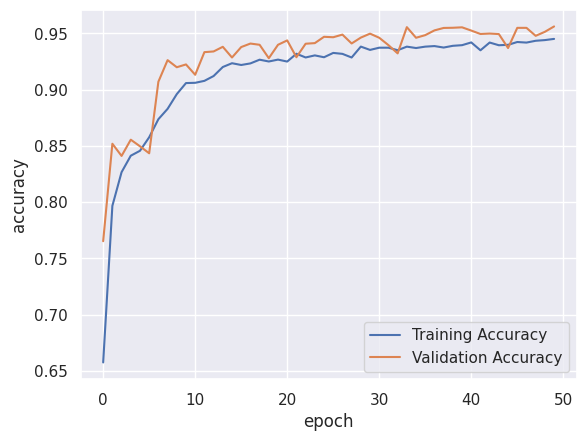

In [51]:
sns.set()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"]) 
plt.show()

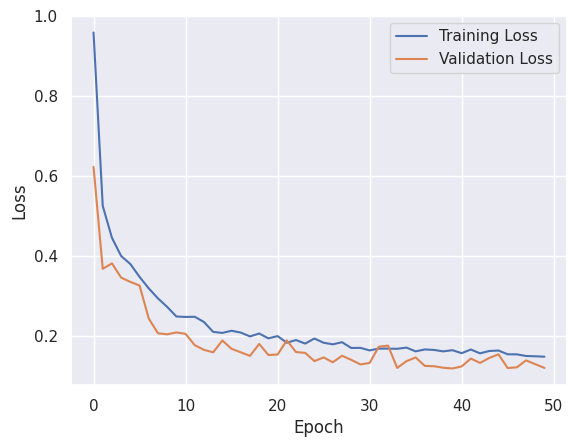

In [52]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [53]:
# predictions
pred = np.argmax(model.predict(X_test), axis=1)

#Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ["Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets", "Bare Soil", "Bitumen", "Self-Blocking Bricks", "Shadows"]))

402/402 [==============================] - 1s 2ms/step
                      precision    recall  f1-score   support

             Asphalt       0.96      0.96      0.96      1990
             Meadows       0.98      0.99      0.98      5558
              Gravel       0.71      0.92      0.80       489
               Trees       0.98      0.97      0.97       932
Painted metal sheets       1.00      1.00      1.00       403
           Bare Soil       0.96      0.94      0.95      1538
             Bitumen       0.94      0.89      0.92       420
Self-Blocking Bricks       0.92      0.84      0.88      1219
             Shadows       1.00      1.00      1.00       284

            accuracy                           0.96     12833
           macro avg       0.94      0.94      0.94     12833
        weighted avg       0.96      0.96      0.96     12833



<AxesSubplot: xlabel='Predicted_Classes', ylabel='Actual_Classes'>

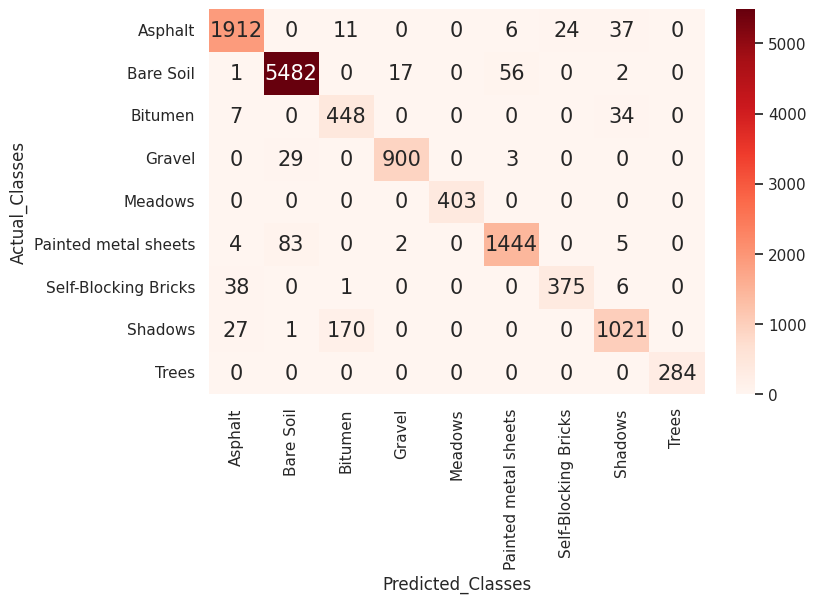

In [54]:
#confusion matrix

matrix = confusion_matrix(pred, np.argmax(y_test, 1))

cmatrix = pd.DataFrame(matrix, columns = np.unique(names), index = np.unique(names))

plt.figure(figsize = (8,5))
cmatrix.index.name = "Actual_Classes"
cmatrix.columns.name = "Predicted_Classes"
sns.heatmap(cmatrix, cmap = "Reds", annot = True, annot_kws = {"size": 15}, fmt = "d")

In [55]:
import math
MSE = np.square(np.subtract(y_test,y_pred)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n", RMSE)

Root Mean Square Error:
 0.08158204290322807


In [56]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error (MAE)", mean_absolute_error(y_test,y_pred))

Mean Absolute Error (MAE) 0.01346751


In [57]:
#l = []

#for i in tqdm(range(pavia_df.shape[0])):
    #if pavia_df.iloc[i, -1] == 0:
        #l.append(0)
    #else:
        #l.append(np.argmax(model.predict(pavia_df.iloc[i, :-1].values.reshape(-1, 103)), 1))
    
#q = np.array(l).reshape(y.shape).astype("float")

#plot_data(q)

/tmp/ipykernel_34/335524737.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clmap = np.array(l).reshape(610, 340).astype("float")


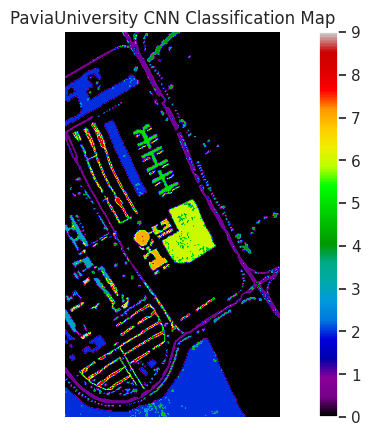

In [58]:
plt.figure(figsize = (10, 5))
clmap = np.array(l).reshape(610, 340).astype("float")
plt.imshow(clmap, cmap = "nipy_spectral")
plt.colorbar()
plt.axis("off")
plt.title("PaviaUniversity CNN Classification Map")
plt.savefig("cnn_classification_map.png")
plt.show()